In [0]:
# Get the apples2oranges dataset
!wget -N http://mmlab.ie.cuhk.edu.hk/archive/sketchdatabase/CUHK/training_88/Cropped_Images/CUHK_training_cropped_sketches.zip -O sketches.zip
!wget -N http://mmlab.ie.cuhk.edu.hk/archive/sketchdatabase/CUHK/training_88/Cropped_Images/CUHK_training_cropped_photos.zip -O photos.zip
!unzip sketches.zip
!unzip photos.zip

for details.

--2019-08-02 04:06:24--  http://mmlab.ie.cuhk.edu.hk/archive/sketchdatabase/CUHK/training_88/Cropped_Images/CUHK_training_cropped_sketches.zip
Resolving mmlab.ie.cuhk.edu.hk (mmlab.ie.cuhk.edu.hk)... 137.189.99.12
Connecting to mmlab.ie.cuhk.edu.hk (mmlab.ie.cuhk.edu.hk)|137.189.99.12|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 708043 (691K) [application/zip]
Saving to: ‘sketches.zip’

sketches.zip        100%[===================>] 691.45K  --.-KB/s    in 0.07s   

2019-08-02 04:06:24 (9.48 MB/s) - ‘sketches.zip’ saved [708043/708043]

for details.

--2019-08-02 04:06:28--  http://mmlab.ie.cuhk.edu.hk/archive/sketchdatabase/CUHK/training_88/Cropped_Images/CUHK_training_cropped_photos.zip
Resolving mmlab.ie.cuhk.edu.hk (mmlab.ie.cuhk.edu.hk)... 137.189.99.12
Connecting to mmlab.ie.cuhk.edu.hk (mmlab.ie.cuhk.edu.hk)|137.189.99.12|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 683334 (667K) [application/zip]
Saving to: ‘

In [0]:
!chmod +x ./sketches/convert.sh
!cd sketches && ./convert.sh

mv: 'convert.sh' and 'convert.sh' are the same file


In [0]:
!sudo pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-xy_s_g6h
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-xy_s_g6h
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp36-none-any.whl size=101066 sha256=17122fe2fe19038e3274278df2adc5a2d9abacce48cc2c4ad86ea69ffbf97ace
  Stored in directory: /tmp/pip-ephem-wheel-cache-4j2an5zy/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


In [0]:
from __future__ import division

import tensorflow as tf

import keras
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input, Conv2D, UpSampling2D, Concatenate
from keras.layers import Activation, AveragePooling2D
from keras.layers.advanced_activations import LeakyReLU
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization

import datetime
import numpy as np
from glob import glob
from PIL import Image

In [0]:
# Data Loader
class DataLoader:
  
  def __init__(self, img_res=(128, 128)):
    self.img_res = img_res

  
  # load the entire dataset
  def load_batch(self, batch_size=1):
    path_photos = glob('photos/*')
    
    self.n_batches = int(len(path_photos) / batch_size)
    
    path_photos = np.random.choice(path_photos, self.n_batches*batch_size, replace=False)
    
    for i in range(self.n_batches):
      batch_photos = path_photos[i*batch_size: (i+1)*batch_size]

      def get_sketch_path(x):
        parts = x.split('/')
        imagename = parts[-1]
        fname, extension = imagename.split('.')
        fname = fname + '-sz1'
        imagename = '.'.join([fname, extension])

        a, b, c, d = imagename.split('-')
        a = a + '2'
        imagename = '-'.join([a, b, c, d])
        return '/'.join(['sketches', imagename])

      batch_sketches = list(map(get_sketch_path, batch_photos))
      
      imgs_A, imgs_B = [], []
      
      for imgA, imgB in zip(batch_photos, batch_sketches):
        imgA = self.get_image(imgA)
        imgB = self.get_image(imgB)
       
        
        # Flip half the images horizontally in training set
        if np.random.random() > 0.5:
          imgA = np.fliplr(imgA)
          imgB = np.fliplr(imgB)
          
        imgs_A.append(imgA)
        imgs_B.append(imgB)
        
      yield (np.array(imgs_A), np.array(imgs_B))
        
        
  def get_image(self, path):
    image = Image.open('./' + path).convert('RGB')
    image = image.resize(self.img_res)
    image = np.array(image)
    image = image / 127.5 - 1
    return image

In [0]:
class CycleGAN():
  
  def __init__(self, rows, cols):
    # Input shapes
    self.img_rows = rows
    self.img_cols = cols
    self.channels = 3
    self.img_shape = (self.img_rows, self.img_cols, self.channels)
    
    # Save network history
    self.history = {
        'd_loss': [],
        'g_loss': []
    }
    
    # Configure the data loader
    self.data_loader = DataLoader(img_res=(rows, cols))
    
    # The output shape of the discriminator (PatchGAN)
    # Discriminator has 4 conv layers with stride = 2.
    patch = int(self.img_rows / 2**4)
    self.disc_patch = (patch, patch, 1)
    
    # Number of filters in the first layer of Generator and Discriminator
    self.gf = 32
    self.df = 64
    
    # The weight each loss should get in the combined loss function
    self.lambda_valid = 1.0                   # Discriminator loss
    self.lambda_cycle = 10.0                  # Cycle-consistency loss 
    self.lambda_id = 0.1 * self.lambda_cycle  # Identity loss
    
    # Optimizer
    optimizer = Adam(0.0002, 0.5)
    
    # Build and compile the discriminators
    self.d_A = self.build_discriminator()    # Discriminator for domain A
    self.d_B = self.build_discriminator()    # Discriminator for domain B
    
    self.d_A.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])
    self.d_B.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])

    # -------------------------------------    
    # Computational graph of the generators
    # -------------------------------------
    
    # Build the generators
    self.g_AB = self.build_generator()       # Generator for domain A -> B
    self.g_BA = self.build_generator()       # Generator for domain B -> A
    
    # Input images from both domains
    img_A = Input(shape=self.img_shape)
    img_B = Input(shape=self.img_shape)
    
    # Translate images to the other domain
    fake_B = self.g_AB(img_A)
    fake_A = self.g_BA(img_B)    
    
    # Translate images back to original domain
    reconstructed_A = self.g_BA(fake_B)
    reconstructed_B = self.g_AB(fake_A)
    
    # Identity mapping of the images
    img_id_A = self.g_BA(img_A)
    img_id_B = self.g_AB(img_B)
    
    # In the combined model, train only the generators
    self.d_A.trainable = False
    self.d_B.trainable = False
    
    # Use discriminators to check validity of images
    valid_A = self.d_A(fake_A)
    valid_B = self.d_B(fake_B)
    
    # Create combined model with discriminator and generator
    self.combined = Model(
      inputs  = [img_A, img_B],
      outputs = [valid_A, valid_B, reconstructed_A, reconstructed_B, img_id_A, img_id_B]
    )
    
    self.combined.compile(
        loss = ['mse', 'mse', 'mae', 'mae', 'mae', 'mae'],
        loss_weights = [
            self.lambda_valid, self.lambda_valid,
            self.lambda_cycle, self.lambda_cycle,
            self.lambda_id, self.lambda_id
        ],
        optimizer = optimizer
    )
    
    
    
  def build_discriminator(self):
    '''Build a discriminator network'''
    
    def d_layer(layer_input, filters, normalization=True):
      '''Discriminator layer'''
      d = Conv2D(filters, kernel_size=4, strides=2, padding='same')(layer_input)
      d = LeakyReLU(alpha=0.2)(d)
      if normalization:
        d = InstanceNormalization()(d)
      return d
      
    
    img = Input(shape=self.img_shape)
    
    d1 = d_layer(img, self.df, normalization=False)
    d2 = d_layer(d1, self.df*2)
    d3 = d_layer(d2, self.df*4)
    d4 = d_layer(d3, self.df*8)
    
    validity = Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)
    
    return Model(img, validity)
  
  
  def build_generator(self):
    '''U-Net Generator
    Ref: https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/
    '''
    
    def conv2d(layer_input, filters):
      '''Layers used during downsampling'''
      d = Conv2D(filters, kernel_size=4, strides=2, padding='same')(layer_input)
      d = LeakyReLU(alpha=0.2)(d)
      d = InstanceNormalization()(d)
      return d
    
    def deconv2d(layer_input, skip_input, filters):
      '''Layers used during upsampling'''
      u = UpSampling2D(size=2)(layer_input)
      u = Conv2D(filters, kernel_size=4, strides=1, padding='same', activation='relu')(u)
      u = InstanceNormalization()(u)
      u = Concatenate()([u, skip_input])
      return u
    
    
    # Image input
    d0 = Input(shape=self.img_shape)
    
    # Downsampling
    d1 = conv2d(d0, self.gf)
    d2 = conv2d(d1, self.gf*2)
    d3 = conv2d(d2, self.gf*4)
    d4 = conv2d(d3, self.gf*8)
    
    # Upsampling
    u1 = deconv2d(d4, d3, self.gf*4)
    u2 = deconv2d(u1, d2, self.gf*2)
    u3 = deconv2d(u2, d1, self.gf)
    
    u4 = UpSampling2D(size=2)(u3)
    output_img = Conv2D(
        self.channels,
        kernel_size=4,
        strides=1,
        padding='same',
        activation='tanh')(u4)
    
    return Model(d0, output_img)
    
  
  def train(self, epochs=20, training_mode=0, batch_size=1, sample_interval=5):
    '''Train the network.
    
    Parameters:
      epochs (int): Number of epochs to train the network for
      training_mode (int):
        0 - train both the discriminator and generator on each batch
        1 - train only the discriminator
        2 - train only the generator
    '''
    
    start_time = datetime.datetime.now()
    
    # Adversarial loss and ground truths
    valid = np.ones((batch_size,) + self.disc_patch)
    fake = np.zeros((batch_size,) + self.disc_patch)
    
    for epoch in range(epochs):
      for batch_idx, (imgs_A, imgs_B) in enumerate(self.data_loader.load_batch(batch_size)):
        # ---------------------
        # Train discriminators
        # ---------------------
        
        # Translate images to opposite domain
        fake_B = self.g_AB.predict(imgs_A)
        fake_A = self.g_BA.predict(imgs_B)
        
        # Train the discriminators with real and fake images
        dA_loss_real = self.d_A.train_on_batch(imgs_A, valid)
        dA_loss_fake = self.d_A.train_on_batch(fake_A, fake)
        dA_loss = 0.5 * np.add(dA_loss_real, dA_loss_fake)
        
        dB_loss_real = self.d_B.train_on_batch(imgs_B, valid)
        dB_loss_fake = self.d_B.train_on_batch(fake_B, fake)
        dB_loss = 0.5 * np.add(dB_loss_real, dB_loss_fake)
        
        # Total discriminator loss
        d_loss = 0.5 * np.add(dA_loss, dB_loss)
        self.history['d_loss'].append(d_loss)
        
        
        # ---------------------------------
        # Train generators (combined model)
        # ---------------------------------
        
        g_loss = self.combined.train_on_batch(
          [imgs_A, imgs_B],
          [valid, valid, imgs_A, imgs_B, imgs_A, imgs_B]
        )
        self.history['g_loss'].append(g_loss)
        
        elapsed_time = datetime.datetime.now() - start_time
        
        # Plot progress
      print ("[Epoch %d/%d] [Batch %d/%d] [D loss: %f, acc: %3d%%] [G loss: %05f, adv: %05f, recon: %05f, id: %05f] time: %s " \
                                                                        % ( epoch+1, epochs,
                                                                            batch_idx, self.data_loader.n_batches,
                                                                            d_loss[0], 100*d_loss[1],
                                                                            g_loss[0],
                                                                            np.mean(g_loss[1:3]),
                                                                            np.mean(g_loss[3:5]),
                                                                            np.mean(g_loss[5:6]),
                                                                            elapsed_time))
        
        
        

In [0]:
net = CycleGAN(256, 256)

In [0]:
net.train(epochs=100, batch_size=1)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


[Epoch 1/100] [Batch 87/88] [D loss: 0.208077, acc:  67%] [G loss: 2.911088, adv: 0.606421, recon: 0.077161, id: 0.096279] time: 0:00:35.223283 
[Epoch 2/100] [Batch 87/88] [D loss: 0.186401, acc:  79%] [G loss: 3.145093, adv: 0.522372, recon: 0.096556, id: 0.108693] time: 0:01:10.222298 
[Epoch 3/100] [Batch 87/88] [D loss: 0.173191, acc:  79%] [G loss: 2.765491, adv: 0.519398, recon: 0.078344, id: 0.087015] time: 0:01:45.259596 
[Epoch 4/100] [Batch 87/88] [D loss: 0.268480, acc:  38%] [G loss: 2.119975, adv: 0.410333, recon: 0.059096, id: 0.066926] time: 0:02:20.285087 
[Epoch 5/100] [Batch 87/88] [D loss: 0.249842, acc:  46%] [G loss: 2.376630, adv: 0.400862, recon: 0.070570, id: 0.095123] time: 0:02:55.397945 
[Epoch 6/100] [Batch 87/88] [D loss: 0.154340, acc:  81%] [G loss: 2.771863, adv: 0.524979, recon: 0.077010, id: 0.127943] time: 0:03:30.499303 
[Epoch 7/100] [Batch 87/88] [D loss: 0.262484, acc:  51%] [G loss: 2.372108, adv: 0.371901, recon: 0.075401, id: 0.072871] time: 0

In [0]:
import matplotlib.pyplot as plt

test_dl = DataLoader(img_res=(256, 256))
batch_gen = test_dl.load_batch(1)


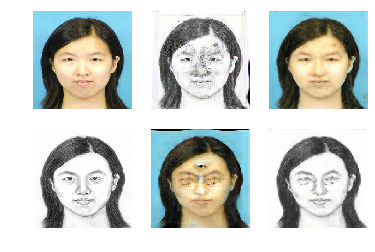

In [0]:
x = next(batch_gen)

apple = x[0]
orange = x[1]

fake_orange = net.g_AB.predict(apple)
fake_apple = net.g_BA.predict(orange)

recon_apple = net.g_BA.predict(fake_orange)
recon_orange = net.g_AB.predict(fake_apple)

gen_imgs = [
    (apple[0] + 1) / 2,
    (fake_orange[0] + 1) / 2,
    (recon_apple[0] + 1) / 2,
    (orange[0] + 1) / 2,
    (fake_apple[0] + 1) / 2,
    (recon_orange[0] + 1) / 2
]

r, c = 2, 3
fig, axs = plt.subplots(r, c)
cnt = 0
for i in range(r):
  for j in range(c):
    axs[i, j].imshow(gen_imgs[cnt])
    axs[i, j].axis('off')
    cnt += 1

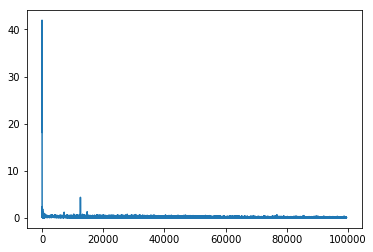

In [0]:
loss_d = list(map(lambda x: x[0], net.history['d_loss']))
acc_d = list(map(lambda x: x[1], net.history['d_loss']))


plt.plot(range(len(loss_d)), loss_d)
plt.plot(range(len(acc_d)), acc_d)
plt.show()

In [0]:
net.g_BA.layers[-1].output

<tf.Tensor 'conv2d_98/Tanh:0' shape=(?, 256, 256, 3) dtype=float32>

In [0]:
net.d_A.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_39 (InputLayer)        (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_240 (Conv2D)          (None, 256, 256, 64)      1792      
_________________________________________________________________
activation_114 (Activation)  (None, 256, 256, 64)      0         
_________________________________________________________________
conv2d_243 (Conv2D)          (None, 256, 256, 128)     73856     
_________________________________________________________________
activation_117 (Activation)  (None, 256, 256, 128)     0         
_________________________________________________________________
conv2d_246 (Conv2D)          (None, 256, 256, 256)     295168    
_________________________________________________________________
activation_120 (Activation)  (None, 256, 256, 256)     0         
__________

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
